# TSNE on the VOC2007 with the second checkpoint

In [2]:
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from torchvision import transforms, datasets
import torchvision.models as models

from voc import Voc2007Classification

from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np


/home/minhan/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load dataset

In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)        
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),        
    transforms.ToTensor(),
    #normalize,
])

#train_dataset = Voc2007Classification('/shared/datasets/project29voc2012/',set='trainval',transform = transform)
val_dataset = Voc2007Classification('/home/minhan/datasets/project29voc/',set='test',transform = transform)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True)

Downloading: "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCdevkit_18-May-2011.tar" to /home/minhan/datasets/project29voc/tmp/VOCdevkit_18-May-2011.tar



VOCdevkit_18-May-2011.tar: 516kB [00:00, 2.93MB/s]                           


[dataset] Extracting tar file /home/minhan/datasets/project29voc/tmp/VOCdevkit_18-May-2011.tar to /home/minhan/datasets/project29voc/
[dataset] Done!
Downloading: "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar" to /home/minhan/datasets/project29voc/tmp/VOCtrainval_06-Nov-2007.tar



VOCtrainval_06-Nov-2007.tar: 460MB [00:04, 112MB/s]                             


[dataset] Extracting tar file /home/minhan/datasets/project29voc/tmp/VOCtrainval_06-Nov-2007.tar to /home/minhan/datasets/project29voc/
[dataset] Done!
Downloading: "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar" to /home/minhan/datasets/project29voc/tmp/VOCtest_06-Nov-2007.tar



VOCtest_06-Nov-2007.tar: 451MB [00:04, 111MB/s]                             


[dataset] Extracting tar file /home/minhan/datasets/project29voc/tmp/VOCtest_06-Nov-2007.tar to /home/minhan/datasets/project29voc/
[dataset] Done!
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/aeroplane_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/bicycle_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/bird_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/boat_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/bottle_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/bus_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/car_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/ImageSets/Main/cat_test.txt
[dataset] read /home/minhan/datasets/project29voc/VOCdevkit/VOC2007/I

In [37]:
mean = [0.49139968, 0.48215827 ,0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]
normalize = transforms.Normalize(mean=mean, std=std)        
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),        
    transforms.ToTensor(),
    normalize,
])

val_dataset = datasets.CIFAR100(root="/home/minhan/", train = True, download=True, transform=transform )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

Files already downloaded and verified


In [3]:
mean = [0.5071, 0.4867,0.4408]
std = [0.2675, 0.2565, 0.2761]
normalize = transforms.Normalize(mean=mean, std=std)        
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),        
    transforms.ToTensor(),
    normalize,
])

val_dataset = datasets.CIFAR100(root="/home/minhan/", train = True, download=True, transform=transform )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

100%|██████████| 169001437/169001437 [00:07<00:00, 23527688.64it/s]


Extracting /home/minhan/cifar-100-python.tar.gz to /home/minhan/


initialize and load models

In [4]:
model = models.__dict__['resnet50'](num_classes=128)

In [5]:
if os.path.isfile('PCL_v2_epoch200.pth'):
    print("=> loading checkpoint '{}'".format('PCL_v2_epoch200.pth'))
    checkpoint = torch.load('PCL_v2_epoch200.pth', map_location="cpu")            
    state_dict = checkpoint['state_dict']
    # rename pre-trained keys
    for k in list(state_dict.keys()):
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            state_dict[k[len("module.encoder_q."):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]  
    model.load_state_dict(state_dict, strict=False)
    model.fc = torch.nn.Identity()
    print("=> loaded pre-trained model '{}'".format('PCL_v2_epoch200.pth'))
else:
    print("=> no checkpoint found at '{}'".format('PCL_v2_epoch200.pth'))

=> loading checkpoint 'PCL_v2_epoch200.pth'
=> loaded pre-trained model 'PCL_v2_epoch200.pth'


cut off last two layers of the resnet (averagepooling and fully connected)

In [6]:
model = torch.nn.Sequential(*list(model.children())[:-2])

In [7]:
device = torch.device('cuda:0')

get features for every datapoint

In [8]:
model.to(device)
model.eval()
features = []
targets = []
with torch.no_grad():
    for data, target in val_loader:
        data = data.cuda()
        feature = model(data)
        feature = torch.flatten(feature, start_dim=1)  # Flatten the feature if necessary
        features.append(feature)
        targets.append(target)

features = torch.cat(features, dim=0)   # Concatenate the feature vectors
targets = torch.cat(targets, dim = 0)

In [9]:
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(features.cpu())

/home/minhan/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/minhan/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


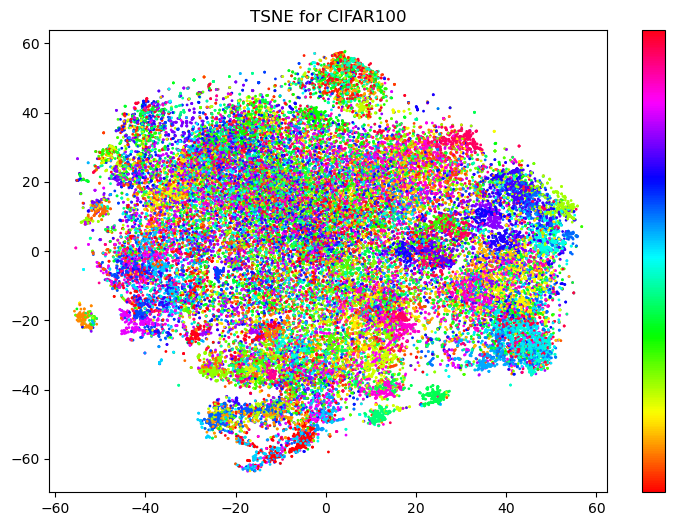

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
# make the scatter
scat = ax.scatter(embeddings[:,0], embeddings[:,1],cmap = 'hsv', c=targets, s=1)

# create a second axes for the colorbar
cbar = fig.colorbar(scat, ticks =[])
ax.set_title('TSNE for CIFAR100')

plt.show()


In [53]:
cifar10_classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

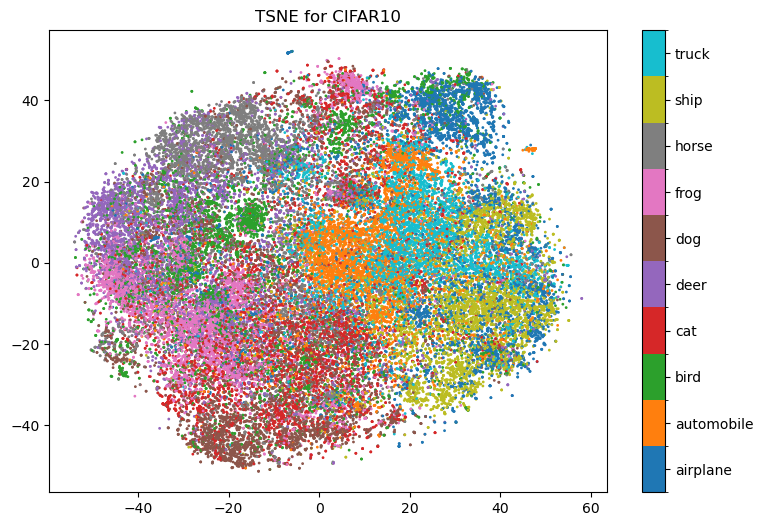

In [88]:
cmap = mcolors.ListedColormap(plt.cm.tab10(range(10)))
norm = mcolors.BoundaryNorm(np.arange(-0.5,10), cmap.N)

fig, ax = plt.subplots(figsize=(9, 6))
# make the scatter
scat = ax.scatter(embeddings[:,0], embeddings[:,1], c=targets, s=1,
                  cmap=cmap, norm=norm)


# create a second axes for the colorbar
cbar = fig.colorbar(scat, ticks=np.linspace(0,9,10))
cbar.ax.set_yticklabels(cifar10_classes)
ax.set_title('TSNE for CIFAR10')

plt.show()


In [146]:
voc2007_labels = [
     'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]


In [ ]:
# Visualize the embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("t-SNE Visualization")
plt.show()

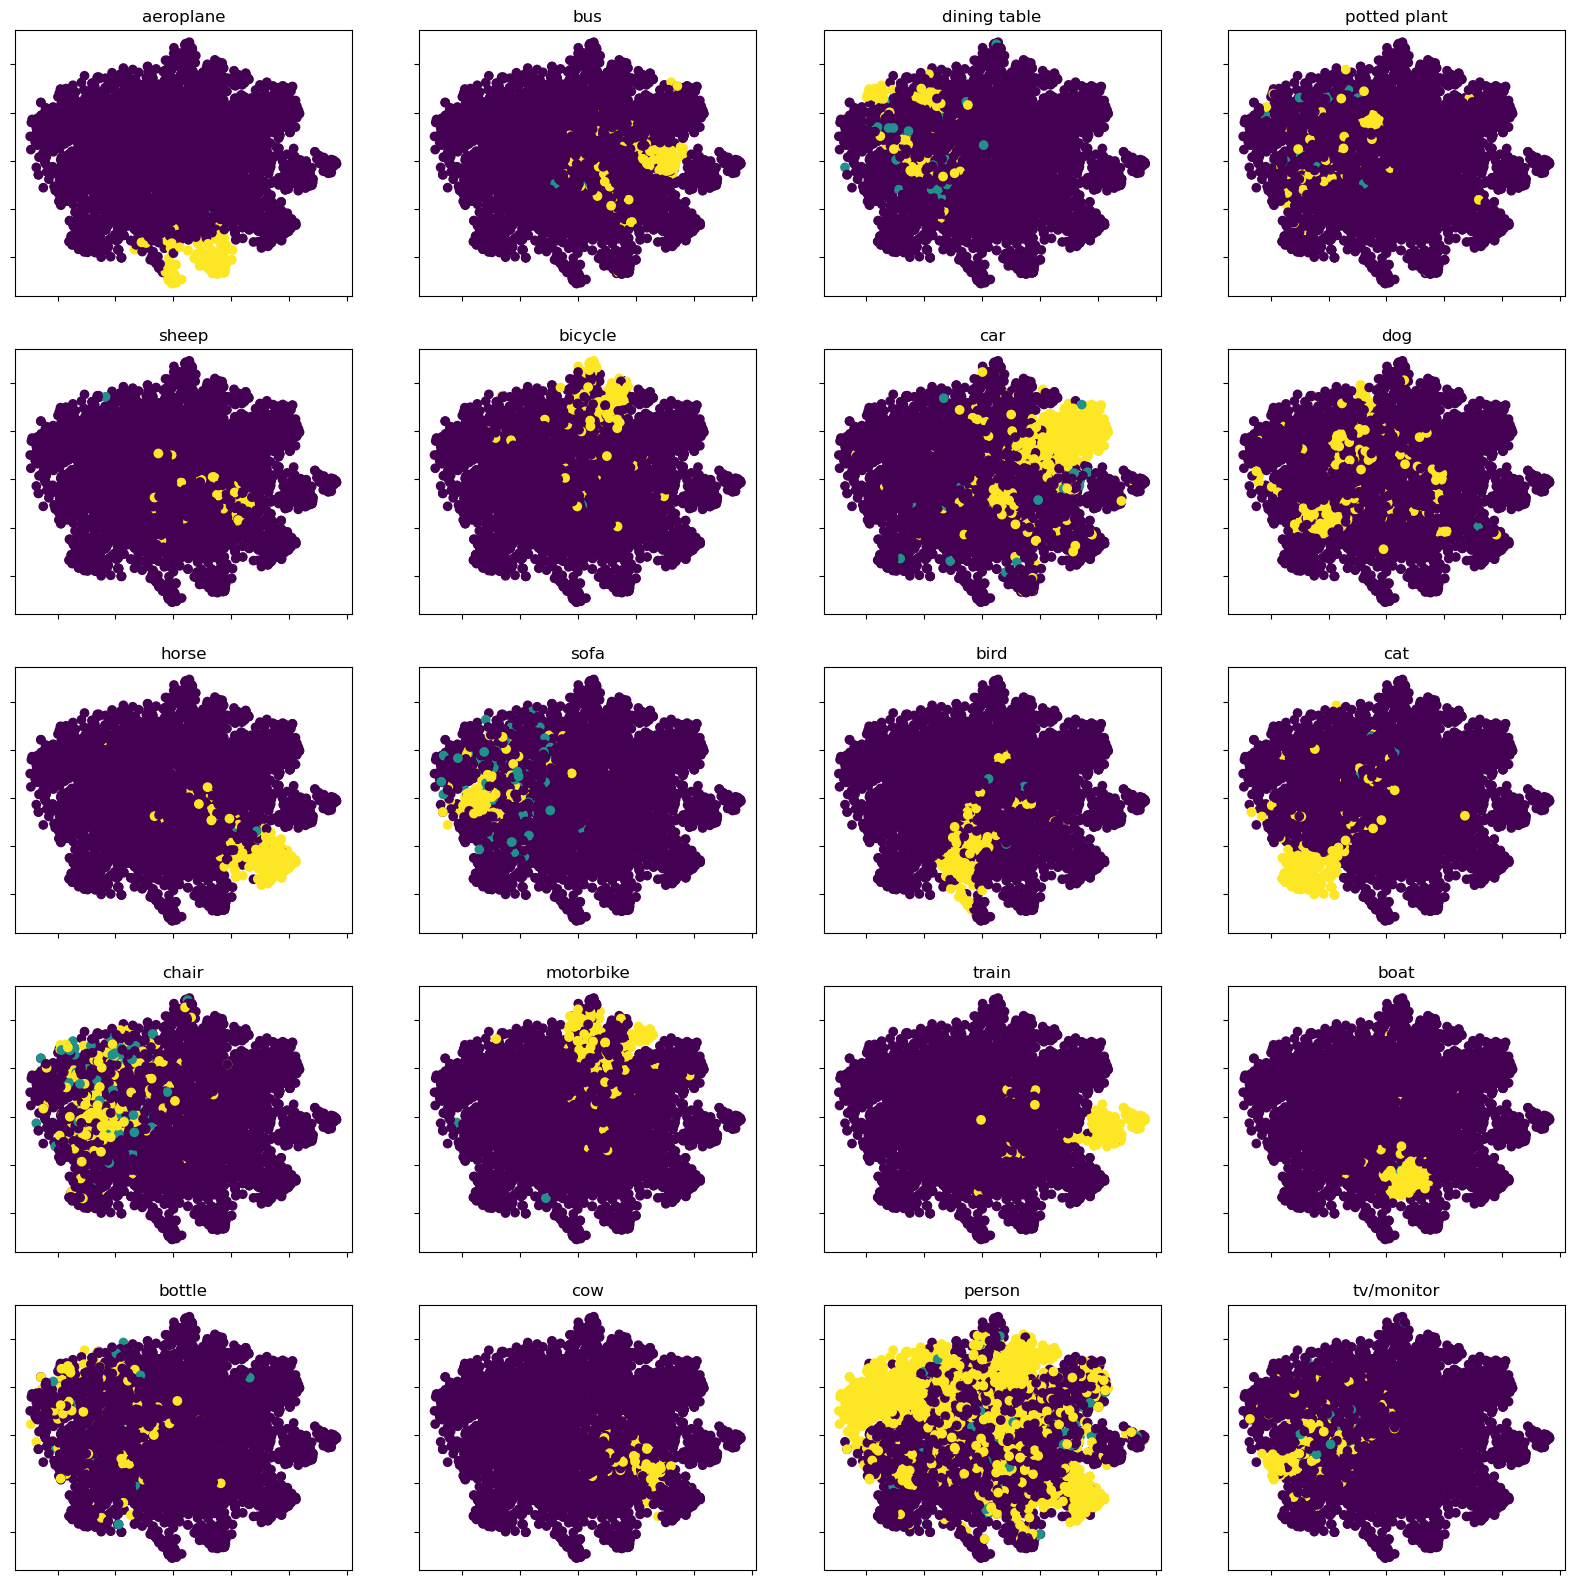

In [147]:
fig, axs = plt.subplots(5, 4)
for i in range(20):
    axs[i % 5, i % 4].scatter(embeddings[:, 0], embeddings[:, 1], c = targets[:,i],cmap='viridis' )
    axs[i % 5, i % 4].set_title(voc2007_labels[i])
    axs[i % 5, i % 4].set_xticklabels([])
    axs[i % 5, i % 4].set_yticklabels([])

fig.set_figheight(20)
fig.set_figwidth(20)


In [138]:
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=3)
embeddings3d = tsne.fit_transform(features.cpu())


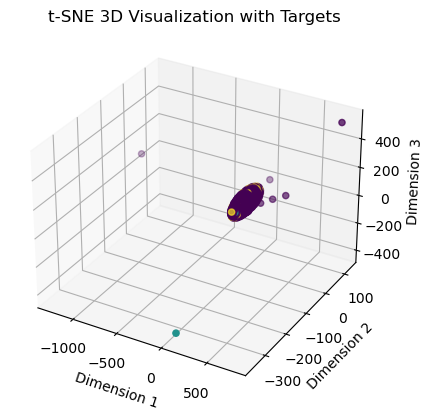

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings3d[:, 0], embeddings3d[:, 1], embeddings3d[:, 2], c=  targets[:,11])
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title("t-SNE 3D Visualization with Targets")
plt.show()